In [37]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score
import sklearn.ensemble as ensemble
from sklearn.metrics import roc_curve, auc, accuracy_score, classification_report, confusion_matrix
import os.path
from scrape_csv import download_online_dat
from sklearn import tree
from pydotplus.graphviz import graph_from_dot_data
import seaborn as sns
from file_writer import df_2_txt_confusion_matrix


In [54]:
def confusion_matrix_heatmap(cm):
    
    #Initialize row names, column names, and values
    
    row_names = cm.index
    col_names = cm.columns
    vals = cm.values
    
    per_true = np.zeros_like(vals, dtype='float')
    
    #Calculate the percents of each true positive and false negative
    
    for el in range(row_names.size):
        per_true[el,:] = vals[el,:]/np.sum(vals[el,:])
    
    per_true = np.around(per_true, decimals=2)
    
    #Mask arrays to plot separately
    
    diag_masked = np.ma.masked_where(per_true == np.diagonal(per_true), per_true)
    rest_masked = np.ma.masked_where(per_true != np.diagonal(per_true), per_true)
    
    fig = plt.figure(figsize=(8,5))
    ax = fig.add_subplot(111, xticks = [], yticks = []) 
    
    #initialize 2 colorbars (Red for Falses, Green for Trues)
    
    im = plt.imshow(rest_masked, cmap='Greens')
    cbarg = plt.colorbar(im, pad=.1, orientation='horizontal', ax=ax)
    cbarg.set_label('Percent True')
    plt.clim(vmin=0,vmax=1.2)
    im1 = plt.imshow(diag_masked, cmap='Reds')
    cbarr = plt.colorbar(im1, pad=.2, orientation='horizontal', ax=ax)
    cbarr.set_label('Percent False')
    plt.clim(vmin=0,vmax=1.2)
    im.set_visible(False)
    im1.set_visible(False)
    
    #Initialize the table for confusion matrix with True data
    
    my_table = plt.table(cellText=rest_masked, cellColours=im.to_rgba(rest_masked), 
                         loc='center', rowLabels=row_names, colLabels=col_names,
                         cellLoc='center', bbox = [0, 0, 2, 1])
    plt.ylabel('test')
    
    #Fill the table with False data
    
    for col in range(diag_masked.shape[1]):
        for row in range(diag_masked.shape[0]):
            if row != col:
                my_table._cells[(row+1,col)]._text.set_text(diag_masked[row,col])
                my_table._cells[(row+1,col)].set_facecolor(im1.to_rgba(diag_masked[row,col]))
    my_table.set_fontsize(30)
    my_table.scale(2,5)
    ax.add_table(my_table)
#    fig.text(.25,.73,'Predicted', fontdict={'fontsize':20})
#    fig.text(-.1,.45, 'True', rotation=90, fontdict={'fontsize':20})
    
    #Save the table to a png file.
    
    plt.tight_layout()
    fig.savefig('test.png', format='png')
    plt.show()



In [39]:
def modelfit(model, predictors, response, title=None, yticks=[None], cv_folds=5, 
             pdf_name='default', optimized=False):
    
    #Set txt file and pdf directories
    
    #pdf_direct = '/users/jnickell/desktop/ML/'
    #txt_direct = '/users/jnickell/desktop/ML/Summer_2018/'
    
    roc_file = 'roc.png'
    fi_file = 'feat_imp.png'
    txt_file = 'model_report.txt'
    
    # Change file depending on optimization
    
    if optimized :
        roc_file = 'optimized_' + roc_file
        fi_file = 'optimized_' + fi_file
        txt_file = 'optimized_' + txt_file
    
    #Train and fit model
    
    train_pred, test_pred, train_vote, test_vote = train_test_split(predictors, response, random_state=rs, test_size=.2)

    model.fit(train_pred, train_vote)
    
    #Choose a tree to print
    
    sub_tree = model.estimators_[42,0]
    
    dot_data = tree.export_graphviz(sub_tree, out_file=None, feature_names=yticks)
    
    graph = graph_from_dot_data(dot_data)

    graph.write_pdf(pdf_name)
    
    # Make predictions 

    pred_vote =  model.predict(test_pred)
    pred_prob = model.predict_proba(test_pred)
    classes = model.classes_
    fpr = dict()
    tpr = dict()
    roc_auc = dict()
    thresh = dict()

    # Analyze metrics and plot an ROC for each class
    
    cv_score = cross_val_score(model, train_pred, train_vote, cv=cv_folds)
    
    for i in range(classes.size):
        fpr[classes[i]], tpr[classes[i]], thresh[classes[i]] = roc_curve(np.array(pd.get_dummies(test_vote))[:,i], np.array(pred_prob)[:,i])
        roc_auc[classes[i]] = auc(fpr[classes[i]],tpr[classes[i]])
        
    accuracy = accuracy_score(test_vote, pred_vote)

    colors = ['navy','cornflowerblue','red']
    
    plt.figure(1)

    for i, color in zip(classes, colors):
        plt.plot(fpr[i], tpr[i], color=color, lw=2,
                 label='ROC curve of class {0} (area = {1:0.2f})'
                 ''.format(i, roc_auc[i]))
        plt.plot([0,1],[0,1], 'k:', label='Random Guessing')
        if title != None :
            plt.title(title)
        plt.legend(loc='best')
        
    plt.text(.6,.4, '\nModel Report \nAccuracy : {0:0.3f} \nCV Results : Mean - {1:0.3f} | Std - {2:0.3f}'.format(accuracy, np.mean(cv_score), np.std(cv_score)))
    
    plt.savefig(roc_file)
    
    
    plt.figure(2)
    
    print('\nModel Report')
    print('Accuracy : {0:0.3f}'.format(accuracy))
    print('CV Results : Mean - {0:0.3f} | Std - {1:0.3f}'.format(np.mean(cv_score), np.std(cv_score)))
        
    feat_imp = model.feature_importances_
    sort = np.argsort(feat_imp)
    pos = np.arange(sort.shape[0]) + .5
    
    plt.barh(pos, feat_imp[sort], align='center')
    if yticks[0] != None:
        plt.yticks(pos, yticks[sort])
    plt.savefig(fi_file)
    
    plt.close('all')
    
    df = pd.DataFrame(confusion_matrix(test_vote, pred_vote), columns=classes, index=classes)
    
    with open(txt_file, 'w') as file:
        file.write('\n'+classification_report(test_vote, pred_vote, labels=classes))
        file.write('\nConfusion Matrix : \n')
    
    df_2_txt_confusion_matrix(df, filename=txt_file)
    
    confusion_matrix_heatmap(df)
     
 

In [40]:
   
#Set URL and csv names

url = 'https://vincentarelbundock.github.io/Rdatasets/csv/carData/BEPS.csv'
#csv_name = '/users/jnickell/desktop/ML/Summer_2018/brit_elect_dat.csv'
csv_name = 'brit_elect_dat.csv'

#Check that data has already been downloaded

if os.path.exists(csv_name) == False:
    download_online_dat(url, csv_name)

#Encode label data

elec_dat = pd.read_csv(csv_name)
elec_dat = elec_dat.drop(['record'],axis=1)
le = LabelEncoder()

elec_dat['gender'] = le.fit_transform(elec_dat['gender'])

corr = elec_dat.copy()
corr['vote'] = le.fit_transform(corr['vote'])

plt.figure(3)

sns.heatmap(corr.corr(), annot=True, cmap='coolwarm', 
            cbar_kws={'label':'Correlation Coeff.'}, vmin=-.5, vmax=1, fmt='.3f',
            annot_kws={'size':'8'})

plt.savefig('jacobtest.png')

plt.close('all')

rs = 42

names = elec_dat.columns
values = elec_dat.values



Model Report
Accuracy : 0.649
CV Results : Mean - 0.684 | Std - 0.007


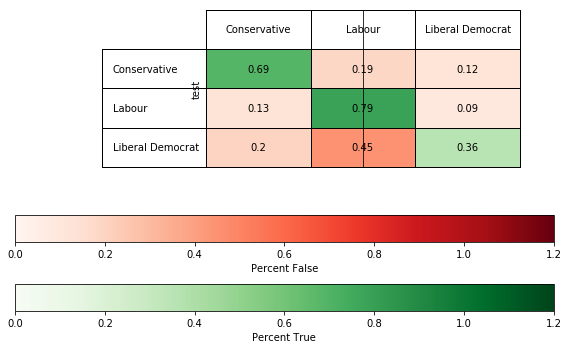

In [55]:
# Initialize predictor and response variables

party = values[:,np.where( names == 'vote')[0]]
party = np.transpose(party)[0]
predictors = values[:,np.where( names != 'vote')[0]]
predictor_names = np.array([x for x in names if x not in ['vote',]])

# Initialize training and testing split, then fit base model

train_pred, test_pred, train_vote, test_vote = train_test_split(predictors, party, random_state=rs, test_size=.2)

gbc = ensemble.GradientBoostingClassifier(random_state=rs)

modelfit(gbc, predictors, party, yticks=predictor_names, title='Not Optimized ROC', 
         pdf_name='unoptimized_tree.pdf')



In [47]:
#initialize a base model

gbc = ensemble.GradientBoostingClassifier(learning_rate=.05, random_state=rs, min_samples_split=10, 
                                          min_samples_leaf=10, max_depth=4, 
                                          max_features='sqrt', subsample=.8)


In [42]:
#Optimize the model

estimator_grid = {'n_estimators' : range(20,101,20)}

estimator_search = GridSearchCV(gbc, param_grid=estimator_grid, cv=5)
estimator_search.fit(train_pred, train_vote)


GridSearchCV(cv=5, error_score='raise',
       estimator=GradientBoostingClassifier(criterion='friedman_mse', init=None,
              learning_rate=0.05, loss='deviance', max_depth=4,
              max_features='sqrt', max_leaf_nodes=None,
              min_impurity_decrease=0.0, min_impurity_split=None,
              min_samples_leaf=10, min_samples_split=10,
              min_weight_fraction_leaf=0.0, n_estimators=100,
              presort='auto', random_state=42, subsample=0.8, verbose=0,
              warm_start=False),
       fit_params=None, iid=True, n_jobs=1,
       param_grid={'n_estimators': range(20, 101, 20)},
       pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
       scoring=None, verbose=0)

In [43]:

gbc.set_params(**estimator_search.best_params_)

depth_split_search = {'max_depth':range(2,7,2), 'min_samples_split':range(20,61,20)}

search2 = GridSearchCV(gbc, param_grid=depth_split_search, cv=5)
search2.fit(train_pred, train_vote)
gbc.set_params(**search2.best_params_)


GradientBoostingClassifier(criterion='friedman_mse', init=None,
              learning_rate=0.05, loss='deviance', max_depth=4,
              max_features='sqrt', max_leaf_nodes=None,
              min_impurity_decrease=0.0, min_impurity_split=None,
              min_samples_leaf=10, min_samples_split=40,
              min_weight_fraction_leaf=0.0, n_estimators=80,
              presort='auto', random_state=42, subsample=0.8, verbose=0,
              warm_start=False)

In [44]:
grid3 = {'min_samples_split':range(20,61,20), 'min_samples_leaf':range(1,6,1)}
search3 = GridSearchCV(gbc, param_grid=grid3, cv=5)
search3.fit(train_pred, train_vote)
gbc.set_params(**search3.best_params_)



GradientBoostingClassifier(criterion='friedman_mse', init=None,
              learning_rate=0.05, loss='deviance', max_depth=4,
              max_features='sqrt', max_leaf_nodes=None,
              min_impurity_decrease=0.0, min_impurity_split=None,
              min_samples_leaf=5, min_samples_split=40,
              min_weight_fraction_leaf=0.0, n_estimators=80,
              presort='auto', random_state=42, subsample=0.8, verbose=0,
              warm_start=False)

In [45]:
grid4 = {'learning_rate' : [.005,.01,.02,.03], 'n_estimators' : range(200,1001,200)}

search4 = GridSearchCV(gbc, param_grid=grid4, cv = 4)
search4.fit(train_pred, train_vote)
gbc.set_params(**search4.best_params_)
print(search2.best_params_, search3.best_params_, search4.best_params_)


KeyboardInterrupt: 

In [ ]:
#Fit the optimized model

modelfit(gbc, predictors, party, yticks=predictor_names, title='Optimized ROC', 
         pdf_name='optimized_tree.pdf', optimized=True)
